In [143]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.count import CountEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate



ModuleNotFoundError: No module named 'sklearn_pandas'

**Note:** 'well', 'pump', 'watersource', etc. etc. are all used interchangeably to refer to the target, which is its function status

In [63]:
!ls TWW_data/

SubmissionFormat.csv
data.csv
status.csv
trimmed_data1025.csv


In [64]:
# import well status and data information
status = pd.read_csv('TWW_data/status.csv', index_col='id')
data = pd.read_csv('TWW_data/data.csv', index_col='id')

In [65]:
# merge both on pump id
df = pd.merge(status, data, on='id')

In [66]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [67]:
# status counts
df['status_group'].value_counts()

functional                 32237
non functional             22813
functional needs repair     4314
Name: status_group, dtype: int64

<AxesSubplot:ylabel='status_group'>

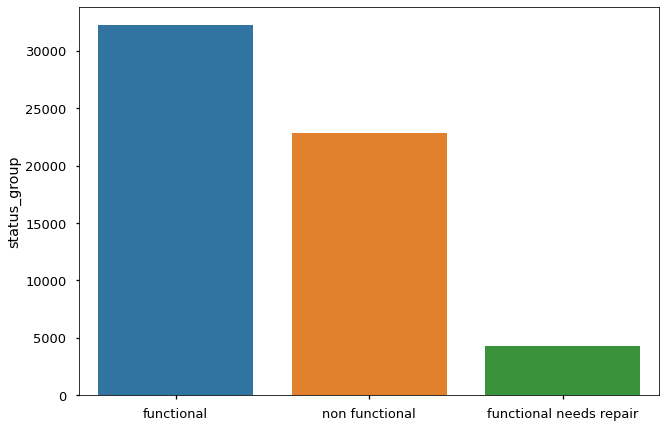

In [68]:
# visualize
sns.barplot(x=df['status_group'].value_counts().index, y=df['status_group'].value_counts())

In [69]:
# combine 'functional needs repair' into 'non functional'
df.loc[df['status_group'] == 'functional needs repair', 'status_group'] = 'non functional'

<AxesSubplot:ylabel='status_group'>

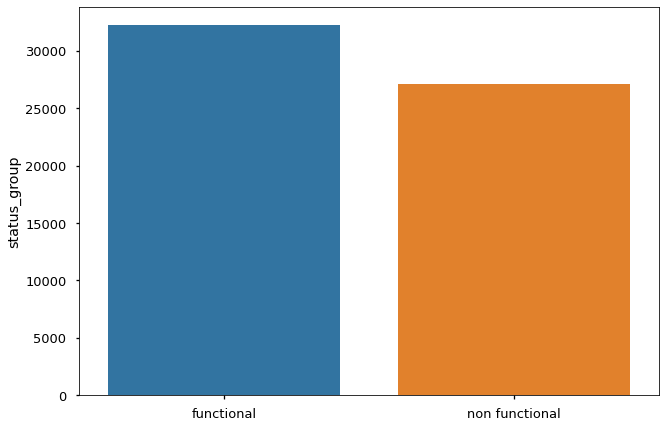

In [70]:
# visualize
## Jen - add pretty labels with capitals, bigger fonts
fig, ax = plt.subplots()
plt.style.use('seaborn-talk')
sns.barplot(x=df['status_group'].value_counts().index, y=df['status_group'].value_counts())
# ax.set_title('')
# ax.set_xlabel('')
# ax.set_ylabel('')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59364 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59364 non-null  object 
 1   amount_tsh             59364 non-null  float64
 2   date_recorded          59364 non-null  object 
 3   funder                 55729 non-null  object 
 4   gps_height             59364 non-null  int64  
 5   installer              55709 non-null  object 
 6   longitude              59364 non-null  float64
 7   latitude               59364 non-null  float64
 8   wpt_name               59364 non-null  object 
 9   num_private            59364 non-null  int64  
 10  basin                  59364 non-null  object 
 11  subvillage             58993 non-null  object 
 12  region                 59364 non-null  object 
 13  region_code            59364 non-null  int64  
 14  district_code          59364 non-null  int64  
 15

In [72]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59364.000000,59364.000000,59364.000000,5.936400e+04,59364.000000,59364.000000,59364.000000,59364.000000,59364.000000
mean,317.843017,668.702513,34.097560,-5.709463e+00,0.474429,15.295516,5.631494,180.019086,1301.441227
std,2998.473133,693.131013,6.517065,2.943608e+00,12.239934,17.592619,9.636138,471.604294,951.369704
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.095187,-8.541904e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,370.000000,34.910318,-5.023822e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1320.000000,37.179490,-3.326918e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [73]:
# separate into numerical and categorical features
cat_cols = []
num_cols = []
for col in df.columns:
    if df[col].dtype in ['object']:
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [74]:
cat_cols

['status_group',
 'date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

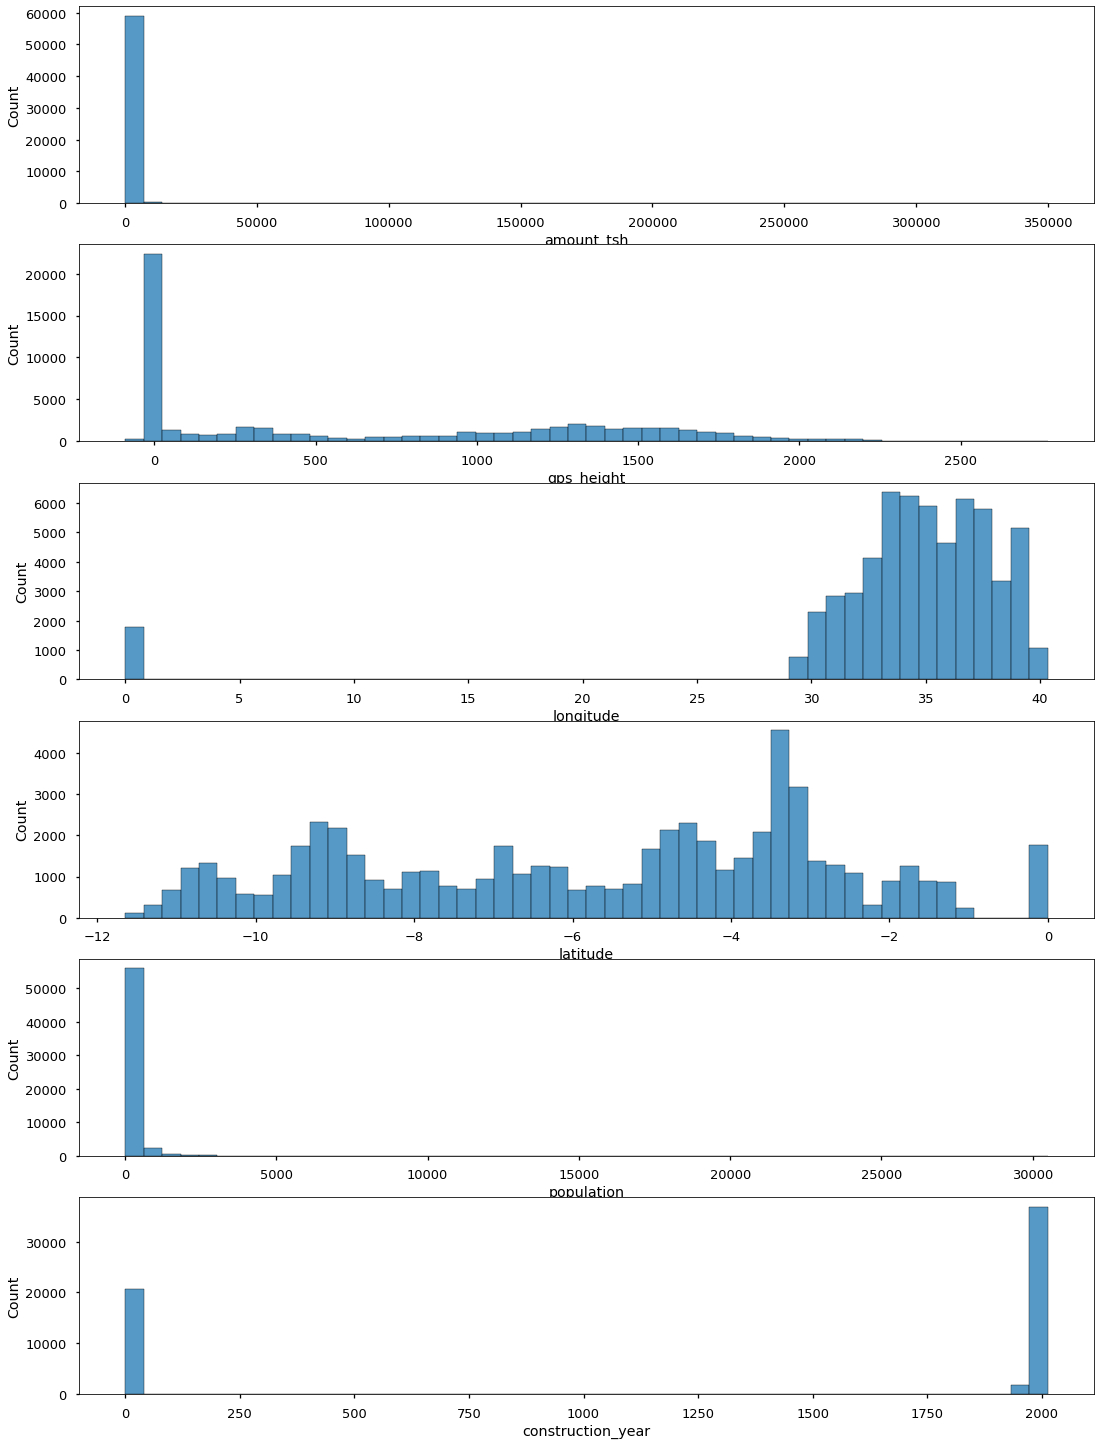

In [75]:
# visualize numericals
fig, axes = plt.subplots(nrows=6,figsize=(15,20))
plt.tight_layout()
for i, col in enumerate(['amount_tsh','gps_height','longitude','latitude','population',
                         'construction_year']):
#     r = i//3
#     c = i%3
    sns.histplot(df[col], bins=50, ax=axes[i])

In [76]:
# check out upper tail of amount_tsh
df['amount_tsh'].sort_values(ascending=False).head(30)

id
41564    350000.0
4128     250000.0
7860     200000.0
70107    170000.0
54154    138000.0
15191    120000.0
71707    117000.0
15801    117000.0
64148    117000.0
38117    117000.0
18724    117000.0
7737     117000.0
4712     117000.0
45188    100000.0
10996    100000.0
69674    100000.0
65614     70000.0
58336     60000.0
24876     50000.0
13946     50000.0
35268     50000.0
3252      50000.0
73818     45000.0
28057     45000.0
30855     45000.0
40048     40000.0
73094     40000.0
28620     40000.0
48346     40000.0
50998     40000.0
Name: amount_tsh, dtype: float64

In [77]:
# check out upper tail of population
df['population'].sort_values(ascending=False).head(30)

id
12169    30500
49354    15300
30750    11463
21166    10000
63349    10000
56570    10000
33117     9865
18520     9500
16664     9000
69166     9000
17459     9000
72820     8848
2118      8600
42967     8500
41994     8200
42627     8000
64021     8000
6280      8000
36272     8000
61539     8000
11002     7530
13182     7500
60098     7500
11571     7500
9941      7000
15841     7000
29054     6922
19042     6922
50707     6922
55230     6922
Name: population, dtype: int64

In [78]:
# percent 0 in each column
(df == 0).sum(axis=0)/len(data)*100

status_group              0.000000
amount_tsh               70.038721
date_recorded             0.000000
funder                    0.000000
gps_height               34.346801
installer                 0.000000
longitude                 2.991582
latitude                  0.000000
wpt_name                  0.000000
num_private              98.664983
basin                     0.000000
subvillage                0.000000
region                    0.000000
region_code               0.000000
district_code             0.038721
lga                       0.000000
ward                      0.000000
population               35.934343
public_meeting            8.508418
recorded_by               0.000000
scheme_management         0.000000
scheme_name               0.000000
permit                   29.410774
construction_year        34.803030
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

### Importance of 0s per column
**Note:** it doesn't matter that `amount_tsh` has a bunch of 0s. The data dictionary describes it as "amount_tsh - Total static head (amount water available to waterpoint)". This might seem quite bad, because this makes it sound like the total water available is 0 for over 70% of water points. However, this is an incorrect description for Total Static Head, as shown [here](images/total_static_head.jpeg). It's simply the distance from the surface of the source to the surface of the access point, so actually having '0' is a good thing.

In [79]:
# percent null in each column
df.isna().sum()/len(data)*100

status_group              0.000000
amount_tsh                0.000000
date_recorded             0.000000
funder                    6.119529
gps_height                0.000000
installer                 6.153199
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
subvillage                0.624579
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.579125
recorded_by               0.000000
scheme_management         6.526936
scheme_name              47.372054
permit                    5.144781
construction_year         0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group    

In [80]:
for col in cat_cols:
    print(f'{col}:')
    print(df[col].value_counts(normalize=True))
    print('<>'*5)

status_group:
functional        0.54304
non functional    0.45696
Name: status_group, dtype: float64
<><><><><>
date_recorded:
2011-03-15    0.009635
2011-03-17    0.009400
2013-02-03    0.009197
2011-03-14    0.008760
2011-03-16    0.008642
                ...   
2011-09-16    0.000017
2004-04-01    0.000017
2004-01-07    0.000017
2013-01-06    0.000017
2004-03-06    0.000017
Name: date_recorded, Length: 356, dtype: float64
<><><><><>
funder:
Government Of Tanzania    0.162860
Danida                    0.055878
Hesawa                    0.039441
Rwssp                     0.024619
World Bank                0.024206
                            ...   
Ldcdd                     0.000018
Act Mara                  0.000018
Pwagu                     0.000018
Kilimo                    0.000018
Brown                     0.000018
Name: funder, Length: 1897, dtype: float64
<><><><><>
installer:
DWE           0.312068
Government    0.032634
RWE           0.021630
Commu         0.019027
DANIDA    

In [81]:
df[cat_cols].describe()

,status_group,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59364,59364,55729,55709,59364,59364,58993,59364,59364,59364,56050,59364,55487,31225,56308,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364,59364
unique,2,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,functional,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,32237,572,9076,17385,3561,10212,505,5294,2503,307,50996,59364,36779,682,38838,26776,26776,26776,40493,52456,25337,25337,50785,50785,33165,33165,17020,17020,45764,28516,34615


In [82]:
((df[cat_cols] == 'None')|(df[cat_cols] == 'none')).sum(axis=0)/len(data)*100

status_group             0.000000
date_recorded            0.000000
funder                   0.003367
installer                0.000000
wpt_name                 5.998316
basin                    0.000000
subvillage               0.000000
region                   0.000000
lga                      0.000000
ward                     0.000000
public_meeting           0.000000
recorded_by              0.000000
scheme_management        0.001684
scheme_name              1.126263
permit                   0.000000
extraction_type          0.000000
extraction_type_group    0.000000
extraction_type_class    0.000000
management               0.000000
management_group         0.000000
payment                  0.000000
payment_type             0.000000
water_quality            0.000000
quality_group            0.000000
quantity                 0.000000
quantity_group           0.000000
source                   0.000000
source_type              0.000000
source_class             0.000000
waterpoint_typ

In [83]:
((df[cat_cols] == 'Unknown')|(df[cat_cols] == 'unknown')).sum(axis=0)/len(data)*100

status_group              0.000000
date_recorded             0.000000
funder                    0.006734
installer                 0.006734
wpt_name                  0.005051
basin                     0.000000
subvillage                0.000000
region                    0.000000
lga                       0.000000
ward                      0.000000
public_meeting            0.000000
recorded_by               0.000000
scheme_management         0.000000
scheme_name               0.000000
permit                    0.000000
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.944444
management_group          0.944444
payment                  13.693603
payment_type             13.693603
water_quality             3.153199
quality_group             3.153199
quantity                  1.328283
quantity_group            1.328283
source                    0.111111
source_type               0.000000
source_class        

Categorical determinations:
- date_recorded - drop
- funder - maybe keep? use with fancy encoder
- installer - fancy encoder
- wpt_name - drop
- basin - FE
- subvillage - too many, drop
- region - use instead of region_code and district_code
- lga - FE (*droppable*)
- ward - drop
- public_meeting - drop
- recorded_by - drop
- secheme_magnement - FE
- secheme_neme - drop
- permit - binary encode
- extraction_type & extraction_type_group - drop
- extraction_type_class - keep, encode
- management - drop
- management_group - FE
- payment - FE
- payment_type - drop (*droppable*)
- water_quality - drop
- quality_group - FE
- quantity - FE
- quantity_group - drop (same)
- source over source_type, keep source_class
- waterpoint_type_group over waterpoint_type

### Testing categorial columns for importance

Do 

In [84]:
# breakdown of status
df['status_group'].value_counts(normalize=True)

functional        0.54304
non functional    0.45696
Name: status_group, dtype: float64

In [85]:
# ratio of funtional to non functional
funct = df['status_group'].value_counts(normalize=True)[0]
ratio = funct/(1-funct)

In [86]:
def important_feat(data,col):
    temp = data.groupby([col, 'status_group']).size()/len(data)*100
    temp = temp.reset_index(name='total_perc')
    rel = temp.groupby(col)['total_perc'].transform(sum)
    temp['rel_perc'] = temp['total_perc']/rel*100
    
    # make dictionary of categories with ratios later
    return temp

In [87]:
important_feat(df, 'extraction_type')

,extraction_type,status_group,total_perc,rel_perc
0,afridev,functional,2.019743,67.778406
1,afridev,non functional,0.960178,32.221594
2,cemo,functional,0.075804,50.000000
3,cemo,non functional,0.075804,50.000000
4,climax,functional,0.013476,25.000000
5,climax,non functional,0.040429,75.000000
6,gravity,functional,27.029850,59.926800
7,gravity,non functional,18.074928,40.073200
8,india mark ii,functional,2.435820,60.300250
9,india mark ii,non functional,1.603666,39.699750


In [88]:
important_feat(df, 'management')

,management,status_group,total_perc,rel_perc
0,company,functional,0.449768,38.978102
1,company,non functional,0.704130,61.021898
2,other,functional,0.850684,59.834123
3,other,non functional,0.571053,40.165877
4,other - school,functional,0.038744,23.232323
5,other - school,non functional,0.128024,76.767677
6,parastatal,functional,1.716529,57.701019
7,parastatal,non functional,1.258338,42.298981
8,private operator,functional,2.486355,74.885845
9,private operator,non functional,0.833839,25.114155


In [89]:
important_feat(df, 'water_quality')

,water_quality,status_group,total_perc,rel_perc
0,coloured,functional,0.414393,50.204082
1,coloured,non functional,0.411024,49.795918
2,fluoride,functional,0.254363,75.500000
3,fluoride,non functional,0.082542,24.500000
4,fluoride abandoned,functional,0.010107,35.294118
5,fluoride abandoned,non functional,0.018530,64.705882
6,milky,functional,0.737821,54.477612
7,milky,non functional,0.616535,45.522388
8,salty,functional,3.739640,45.716639
9,salty,non functional,4.440402,54.283361


In [90]:
drop_cols = ['num_private', 'region_code', 'district_code', 'date_recorded', 
             'wpt_name', 'subvillage', 'ward', 'public_meeting',
             'recorded_by', 'scheme_name', 'extraction_type', 'extraction_type_group',
             'management', 'payment_type', 'water_quality', 'quantity_group',
             'source_type', 'waterpoint_type']
df.drop(columns=drop_cols, inplace=True)

In [91]:
(df['longitude'] == 0).sum()

1777

In [92]:
(df['latitude'] == 0).sum()

0

In [93]:
df[df['longitude'] == 0]['latitude'].value_counts()

-2.000000e-08    1777
Name: latitude, dtype: int64

In [94]:
# transform incorrect long/lat to nulls 
df.loc[(df['longitude']== 0), ('longitude','latitude')] = np.nan

In [113]:
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in df.columns:
    if df[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif df[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)
        
print(num_cols, sm_cat_cols, lg_cat_cols)

sm_cat_cols = sm_cat_cols[1:] 

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year'] ['status_group', 'basin', 'region', 'scheme_management', 'permit', 'extraction_type_class', 'management_group', 'payment', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type_group'] ['funder', 'installer', 'lga']


['basin',
 'region',
 'scheme_management',
 'permit',
 'extraction_type_class',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type_group']

In [96]:
X = df.drop(columns='status_group')
y = df['status_group']

In [97]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = .25, random_state = 396)

In [98]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_holdout.shape, y_holdout.shape

((40070, 21), (40070,), (13357, 21), (13357,), (5937, 21), (5937,))

### Pre-modeling transformations

**NUMERIC COLUMNS**

-Create new t/f columns for construction year and population
- MinMaxScaler - assumes normal distribution
- IterativeImputer
    - population
    - construction year
    - lat/long - 0's only incorrect in longitude 

**CATEGORICAL COLUMNS**
- Fill in blanks w/ sklearn.impute.IterativeImputer¶



In [172]:
#creating Pipelines for each column type: numeric, categorical with under 10 categories, categorical with over 10 categories
#We moved iterative imputer to numeric columns because it will only work on numerics

num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer()),
    ('mm', MinMaxScaler())
    
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(drop = 'first'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])




### Important Note About IterativeImputer text

This is straight up copied from : https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
So if we use any of the below we need to rewrite and cite

In [174]:
#Allows you to see all columns when displaying dataframe
pd.get_option("display.max_columns")

In [177]:
#Getting rin of nan values in categoricals. Everything breaks if they remain
nan_cols = ['funder', 'installer', 'scheme_management', 'permit']

for col in nan_cols:
    X_train[col].fillna('Unknown', inplace = True)



In [179]:
#Must get rid of mix of boolean and string, could not be processed
X_train['permit'] = X_train['permit'].astype(str)
X_train.isna().sum()

amount_tsh                  0
funder                      0
gps_height                  0
installer                   0
longitude                1204
latitude                 1204
basin                       0
region                      0
lga                         0
population                  0
scheme_management           0
permit                      0
construction_year           0
extraction_type_class       0
management_group            0
payment                     0
quality_group               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
dtype: int64

In [181]:
#This works!
col_trans = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])

In [182]:
#We had to move away from pipelines to diagnose errors, however can move back to pipelines

x_train_transformed = col_trans.fit_transform(x_train_reset)

In [183]:
dec_tree = DecisionTreeClassifier(max_depth = 10)

In [184]:
dec_tree.fit(x_train_transformed, y_train)

DecisionTreeClassifier(max_depth=10)

In [186]:
#Alex and Jen stopped here, we are dead.
dec_tree.score(x_train_transformed, y_train)

0.7943848265535313

In [159]:
model_pipe_dec_tree = Pipeline(steps =[
    
    ('dec_tree', DecisionTreeClassifier(max_depth = 10))
])

In [161]:
cross_val_results = cross_validate(model_pipe_dec_tree, x_train_reset, y_train_reset, cv = 3, scoring = ('accuracy', 'f1', 'precision', 'recall'))

C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\tree\_classes.py", line 156, in fit
    X, y = self._validate_data(X, y,
  File "C:\Users\Jenny\anaconda3.1\envs\learn-env\lib\site-packages\sklearn\base.py", line 429, in

In [51]:
test_dict = {'dec_tree':KNeighborsClassifier(), 'lr':LogisticRegression()}

def basic_model_tests(X, y, test_dict):
    '''Takes in X and y data as well as dictionary of name:test entries to run'''
    scores = []
    for key, value in test_dict.items():
        test_model_loop = Pipeline(steps=[
            (key, value)
        ])
        test_model_loop.fit(X, y)
        score = test_model_loop.score(X, y)
        scores.append({'name':key, 'type':value, 'score':score})
    return scores

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
test_list = [{'name':'knn', 'type': KNeighborsClassifier(), 'params':{'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3]}},
            {'name': 'lr', 'type': LogisticRegression(), 'params':{'lr__fit_intercept':[False], 'lr__C':[1, 1000, 1e12],
                                                                  'lr__solver':['liblinear','newton-cg', 'lbfgs']}}]
#fit_intercept=False, C= 1e12, solver='liblinear'

In [ ]:
def model_tests(X, y, test_list):
    '''Takes in X and y data as well as a list of dictionaries'''
    scores = []
    for x in test_list:
        test_model_loop = Pipeline(steps=[
            (x['name'], x['type'])
        ])
        test_model_loop.fit(X, y)
#         score = test_model_loop.score(X, y)
#         scores.append({'name':x['name'], 'type':x['type'], 'score':score})
        
        gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
        gs_pipe.fit(X,y)
        scores.append(gs_pipe.cv_results_)
    return scores

In [ ]:
scores = model_tests(X_train_clean, y_train, test_list)


for x in scores:
    
    print(pd.DataFrame(x))